In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import json
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image

In [2]:
def setup_environment():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
    pretrained_model = pretrained_model.to(device)
    pretrained_model.eval()

    # Normalization parameters
    mean_norms = np.array([0.485, 0.456, 0.406])
    std_norms = np.array([0.229, 0.224, 0.225])

    return device, pretrained_model, mean_norms, std_norms

def load_dataset(mean_norms, std_norms):
    # Extract dataset
    !unzip -q TestDataSet.zip
    !rm -r __MACOSX

    # Transforms for normalization
    plain_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_norms, std=std_norms)
    ])

    # Load dataset
    dataset_path = "./TestDataSet"
    dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
    data_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)

    # Load label mapping
    json_path = "./TestDataSet/labels_list.json"
    with open(json_path, "r") as f:
        class_labels = json.load(f)

    # Extract class indices
    imagenet_indices = []
    for item in class_labels:
        idx_str, _ = item.split(": ", 1)
        idx = int(idx_str)
        imagenet_indices.append(idx)

    # Folder index to ImageNet index mapping
    folder_idx_to_imagenet_idx = {i: imagenet_indices[i] for i in range(len(imagenet_indices))}

    return dataset, data_loader, folder_idx_to_imagenet_idx

def denormalize(tensor, mean_norms, std_norms):
    tensor = tensor.clone().detach().cpu()
    for t, m, s in zip(tensor, mean_norms, std_norms):
        t.mul_(s).add_(m)
    return tensor.permute(1, 2, 0).numpy().clip(0, 1)

def create_output_directories(output_path, dataset):
    os.makedirs(output_path, exist_ok=True)
    for class_name in dataset.classes:
        os.makedirs(os.path.join(output_path, class_name), exist_ok=True)

# Set up the environment
device, pretrained_model, mean_norms, std_norms = setup_environment()
dataset, data_loader, folder_idx_to_imagenet_idx = load_dataset(mean_norms, std_norms)

print(f"Device: {device}")
print(f"Dataset size: {len(dataset)} images")
print(f"Number of classes: {len(dataset.classes)}")

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 197MB/s]


Device: cuda
Dataset size: 500 images
Number of classes: 100


# **Task 1**

In [3]:
# Running inference on the test dataset
top1_correct = 0
top5_correct = 0
total = 0

In [4]:
with torch.no_grad():
    for images, labels in tqdm(data_loader):
        images = images.to(device)

        # Map folder indices to ImageNet indices
        imagenet_labels = torch.tensor([folder_idx_to_imagenet_idx[label.item()] for label in labels]).to(device)

        outputs = pretrained_model(images)

        # Calculate top-1 accuracy
        _, predicted = torch.max(outputs, 1)
        top1_correct += (predicted == imagenet_labels).sum().item()

        # Calculate top-5 accuracy
        _, top5_indices = torch.topk(outputs, 5, dim=1)
        for i in range(imagenet_labels.size(0)):
            if imagenet_labels[i] in top5_indices[i]:
                top5_correct += 1

        total += imagenet_labels.size(0)

100%|██████████| 500/500 [00:04<00:00, 103.58it/s]


In [5]:
# Computing top-1 and top-5 accuracy
top1_accuracy = top1_correct / total
top5_accuracy = top5_correct / total

print(f"Top-1 Accuracy: {top1_accuracy:.4f}")
print(f"Top-5 Accuracy: {top5_accuracy:.4f}")

Top-1 Accuracy: 0.7600
Top-5 Accuracy: 0.9420


# **Task 2**

In [6]:
# FGSM Attack Function

def fgsm_attack(image, target, model, mean_norms, std_norms, epsilon=0.02):

    # Set requires_grad attribute of tensor
    image.requires_grad = True

    # Forward pass
    output = model(image)

    # Calculate loss
    loss = torch.nn.functional.cross_entropy(output, target)

    # Zero gradients
    model.zero_grad()

    # Backward pass to get gradients
    loss.backward()

    # Get sign of gradient
    sign_data_grad = image.grad.sign()

    # Create perturbed image
    perturbed_image = image + epsilon * sign_data_grad

    # Clamp to valid range for each normalized channel
    for c, (mean, std) in enumerate(zip(mean_norms, std_norms)):
        perturbed_image[0, c] = torch.clamp(perturbed_image[0, c],
                                          (0 - mean) / std,
                                          (1 - mean) / std)

    return perturbed_image.detach()

100%|██████████| 500/500 [00:16<00:00, 31.01it/s]


Original Top-1 Accuracy: 0.7600
Original Top-5 Accuracy: 0.9420
FGSM Adversarial Top-1 Accuracy: 0.0620
FGSM Adversarial Top-5 Accuracy: 0.3560
Top-1 Accuracy Drop: 0.6980 (91.84%)
Top-5 Accuracy Drop: 0.5860 (62.21%)


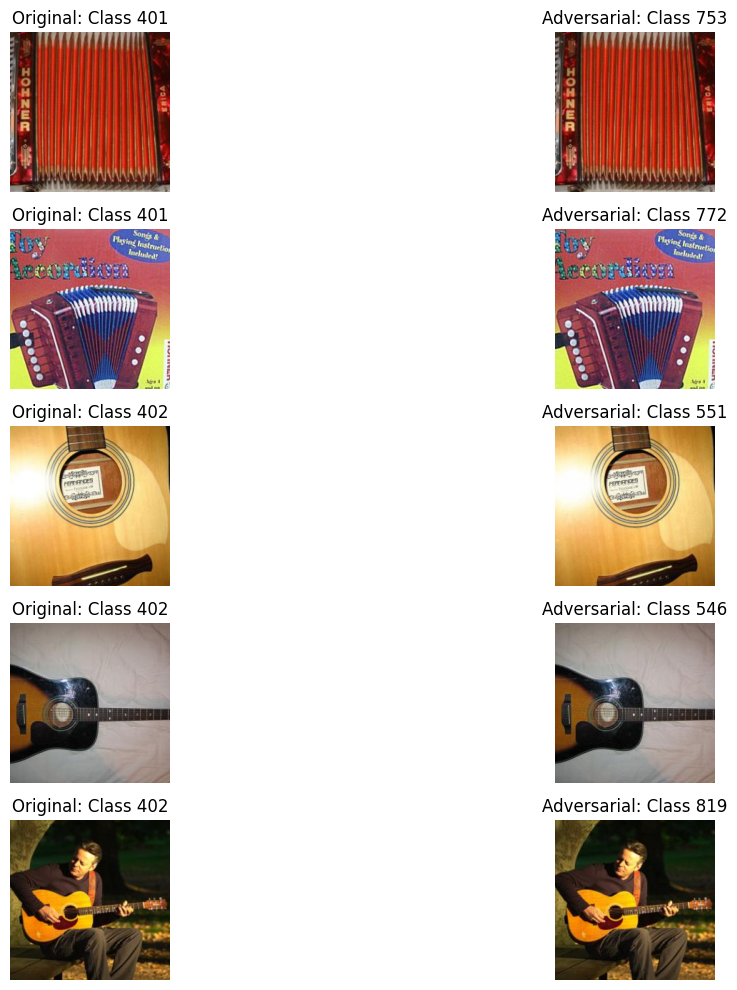

In [7]:
# Run FGSM Attack

def run_fgsm_attack():
    # Create output directory
    adv_dataset_path = "./AdversarialTestSet1"
    create_output_directories(adv_dataset_path, dataset)

    # Attack parameters
    epsilon = 0.02

    # Apply FGSM to each image
    successful_examples = []
    top1_correct = 0
    top5_correct = 0
    total = 0

    for i, (image, label) in enumerate(tqdm(data_loader)):
        # Move to device
        image, label = image.to(device), label.to(device)

        # Get ImageNet label
        imagenet_label = torch.tensor([folder_idx_to_imagenet_idx[label.item()]]).to(device)

        # Get original prediction
        with torch.no_grad():
            orig_output = pretrained_model(image)
            _, orig_pred = torch.max(orig_output, 1)
            orig_correct = (orig_pred == imagenet_label).item()

        # Apply FGSM attack
        adv_image = fgsm_attack(
            image,
            imagenet_label,
            pretrained_model,
            mean_norms,
            std_norms,
            epsilon=epsilon
        )

        # Verify L-infinity constraint
        l_inf_dist = (adv_image - image).abs().max().item()
        tolerance = 1e-6  # Small tolerance for floating point precision
        assert l_inf_dist <= epsilon + tolerance, f"L-infinity distance ({l_inf_dist}) exceeds epsilon ({epsilon})"

        # Save adversarial image
        folder_name = dataset.classes[label.item()]
        img_path, _ = dataset.samples[i]
        img_name = os.path.basename(img_path)

        adv_img_path = os.path.join(adv_dataset_path, folder_name, img_name)
        adv_img_np = denormalize(adv_image.squeeze(0), mean_norms, std_norms)
        adv_img_pil = Image.fromarray((adv_img_np * 255).astype(np.uint8))
        adv_img_pil.save(adv_img_path)

        # Evaluate adversarial image
        with torch.no_grad():
            adv_output = pretrained_model(adv_image)

            # Calculate top-1 accuracy
            _, adv_pred = torch.max(adv_output, 1)
            adv_correct = (adv_pred == imagenet_label).item()
            top1_correct += adv_correct

            # Calculate top-5 accuracy
            _, top5_indices = torch.topk(adv_output, 5, dim=1)
            if imagenet_label.item() in top5_indices[0]:
                top5_correct += 1

        total += 1

        # Store successful examples for visualization
        if orig_correct and not adv_correct and len(successful_examples) < 5:
            successful_examples.append({
                'original': image.detach().cpu().squeeze(0),
                'adversarial': adv_image.detach().cpu().squeeze(0),
                'original_pred': orig_pred.item(),
                'adversarial_pred': adv_pred.item(),
                'true_label': imagenet_label.item()
            })

    # Calculate accuracy metrics
    adv_top1_accuracy = top1_correct / total
    adv_top5_accuracy = top5_correct / total

    print(f"Original Top-1 Accuracy: 0.7600")
    print(f"Original Top-5 Accuracy: 0.9420")
    print(f"FGSM Adversarial Top-1 Accuracy: {adv_top1_accuracy:.4f}")
    print(f"FGSM Adversarial Top-5 Accuracy: {adv_top5_accuracy:.4f}")
    print(f"Top-1 Accuracy Drop: {0.7600 - adv_top1_accuracy:.4f} ({(0.7600 - adv_top1_accuracy)/0.7600*100:.2f}%)")
    print(f"Top-5 Accuracy Drop: {0.9420 - adv_top5_accuracy:.4f} ({(0.9420 - adv_top5_accuracy)/0.9420*100:.2f}%)")

    # Visualize examples
    visualize_examples(successful_examples, 'fgsm')


    return successful_examples

def visualize_examples(examples, attack_name):
    """Visualize examples of successful adversarial attacks."""
    plt.figure(figsize=(15, 10))

    for i, example in enumerate(examples):
        # Original image
        plt.subplot(len(examples), 2, 2*i+1)
        plt.imshow(denormalize(example['original'], mean_norms, std_norms))
        plt.title(f"Original: Class {example['original_pred']}")
        plt.axis('off')

        # Adversarial image
        plt.subplot(len(examples), 2, 2*i+2)
        plt.imshow(denormalize(example['adversarial'], mean_norms, std_norms))
        plt.title(f"Adversarial: Class {example['adversarial_pred']}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f"{attack_name}_examples.png")
    plt.show()

# Run FGSM attack
fgsm_examples = run_fgsm_attack()

In [ ]:
# Zip the results
!zip -r AdversarialTestSet1.zip /content/AdversarialTestSet1

# **Task 3**

In [9]:
# PGD Attack Implementation

def pgd_attack(image, target, model, mean_norms, std_norms, epsilon=0.02, alpha=0.005, iterations=10):
    # Create a copy of the original image
    perturbed_image = image.clone().detach()

    # Add small random noise to start from a different point
    perturbed_image = perturbed_image + torch.zeros_like(perturbed_image).uniform_(-epsilon/8, epsilon/8)

    # Ensure starting point is valid
    for c, (mean, std) in enumerate(zip(mean_norms, std_norms)):
        min_val = (0 - mean) / std
        max_val = (1 - mean) / std
        perturbed_image[0, c] = torch.clamp(perturbed_image[0, c], min_val, max_val)

    for i in range(iterations):
        # Set requires_grad attribute
        perturbed_image.requires_grad = True

        # Forward pass
        output = model(perturbed_image)

        # Calculate loss
        loss = torch.nn.functional.cross_entropy(output, target)

        # Zero gradients
        model.zero_grad()

        # Backward pass
        loss.backward()

        # Get gradient sign
        grad_sign = perturbed_image.grad.sign()

        # Update image (detach to prepare for next iteration)
        perturbed_image = perturbed_image.detach()

        # Take a step in the direction of the gradient
        perturbed_image = perturbed_image + alpha * grad_sign

        # Project back onto epsilon ball centered at original image
        delta = perturbed_image - image
        delta = torch.clamp(delta, -epsilon, epsilon)
        perturbed_image = image + delta

        # Ensure the perturbed image is within valid bounds
        for c, (mean, std) in enumerate(zip(mean_norms, std_norms)):
            min_val = (0 - mean) / std
            max_val = (1 - mean) / std
            perturbed_image[0, c] = torch.clamp(perturbed_image[0, c], min_val, max_val)

    return perturbed_image.detach()

100%|██████████| 500/500 [01:53<00:00,  4.42it/s]


Original Top-1 Accuracy: 0.7600
Original Top-5 Accuracy: 0.9420
FGSM Adversarial Top-1 Accuracy: 0.0620
FGSM Adversarial Top-5 Accuracy: 0.3540
PGD Adversarial Top-1 Accuracy: 0.0000
PGD Adversarial Top-5 Accuracy: 0.0980
Top-1 Accuracy Drop: 0.7600 (100.00%)
Top-5 Accuracy Drop: 0.8440 (89.60%)


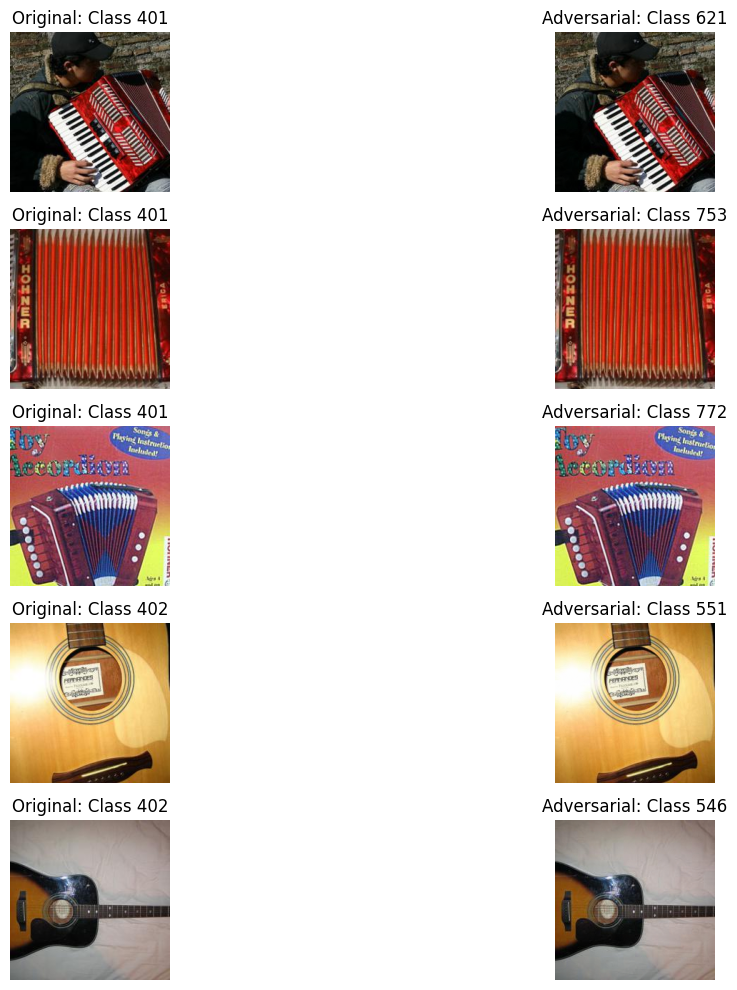

In [10]:
# Run PGD Attack

def run_pgd_attack():
    # Create output directory
    adv_dataset_path = "./AdversarialTestSet2"
    create_output_directories(adv_dataset_path, dataset)

    # Attack parameters
    epsilon = 0.02
    alpha = 0.004  # Step size
    iterations = 15  # Number of iterations

    # Apply PGD to each image
    successful_examples = []
    top1_correct = 0
    top5_correct = 0
    total = 0

    for i, (image, label) in enumerate(tqdm(data_loader)):
        # Move to device
        image, label = image.to(device), label.to(device)

        # Get ImageNet label
        imagenet_label = torch.tensor([folder_idx_to_imagenet_idx[label.item()]]).to(device)

        # Get original prediction
        with torch.no_grad():
            orig_output = pretrained_model(image)
            _, orig_pred = torch.max(orig_output, 1)
            orig_correct = (orig_pred == imagenet_label).item()

        # Apply PGD attack
        adv_image = pgd_attack(
            image,
            imagenet_label,
            pretrained_model,
            mean_norms,
            std_norms,
            epsilon=epsilon,
            alpha=alpha,
            iterations=iterations
        )

        # Verify L-infinity constraint
        l_inf_dist = (adv_image - image).abs().max().item()
        tolerance = 1e-6  # Small tolerance for floating point precision
        assert l_inf_dist <= epsilon + tolerance, f"L-infinity distance ({l_inf_dist}) exceeds epsilon ({epsilon})"

        # Save adversarial image
        folder_name = dataset.classes[label.item()]
        img_path, _ = dataset.samples[i]
        img_name = os.path.basename(img_path)

        adv_img_path = os.path.join(adv_dataset_path, folder_name, img_name)
        adv_img_np = denormalize(adv_image.squeeze(0), mean_norms, std_norms)
        adv_img_pil = Image.fromarray((adv_img_np * 255).astype(np.uint8))
        adv_img_pil.save(adv_img_path)

        # Evaluate adversarial image
        with torch.no_grad():
            adv_output = pretrained_model(adv_image)

            # Calculate top-1 accuracy
            _, adv_pred = torch.max(adv_output, 1)
            adv_correct = (adv_pred == imagenet_label).item()
            top1_correct += adv_correct

            # Calculate top-5 accuracy
            _, top5_indices = torch.topk(adv_output, 5, dim=1)
            if imagenet_label.item() in top5_indices[0]:
                top5_correct += 1

        total += 1

        # Store successful examples for visualization
        if orig_correct and not adv_correct and len(successful_examples) < 5:
            successful_examples.append({
                'original': image.detach().cpu().squeeze(0),
                'adversarial': adv_image.detach().cpu().squeeze(0),
                'original_pred': orig_pred.item(),
                'adversarial_pred': adv_pred.item(),
                'true_label': imagenet_label.item()
            })

    # Calculate accuracy metrics
    adv_top1_accuracy = top1_correct / total
    adv_top5_accuracy = top5_correct / total

    print(f"Original Top-1 Accuracy: 0.7600")
    print(f"Original Top-5 Accuracy: 0.9420")
    print(f"FGSM Adversarial Top-1 Accuracy: 0.0620")
    print(f"FGSM Adversarial Top-5 Accuracy: 0.3540")
    print(f"PGD Adversarial Top-1 Accuracy: {adv_top1_accuracy:.4f}")
    print(f"PGD Adversarial Top-5 Accuracy: {adv_top5_accuracy:.4f}")
    print(f"Top-1 Accuracy Drop: {0.7600 - adv_top1_accuracy:.4f} ({(0.7600 - adv_top1_accuracy)/0.7600*100:.2f}%)")
    print(f"Top-5 Accuracy Drop: {0.9420 - adv_top5_accuracy:.4f} ({(0.9420 - adv_top5_accuracy)/0.9420*100:.2f}%)")

    # Visualize examples
    visualize_examples(successful_examples, 'pgd')


    return successful_examples

# Run PGD attack
pgd_examples = run_pgd_attack()

In [ ]:
# Zip the results
!zip -r AdversarialTestSet2.zip /content/AdversarialTestSet2

# **Task 4**

In [12]:
def targeted_patch_attack(image, true_label, model, mean_norms, std_norms,
                         patch_size=32, epsilon=0.5, alpha=0.1, iterations=120,
                         use_saliency=True):

    # Get image dimensions (assuming 1, C, H, W)
    _, C, H, W = image.shape

    # Start with the original image
    image_adv = image.clone().detach()
    image_original = image.clone().detach()  # For perturbation calculation

    # Choose patch location
    # Ensure patch fits within image dimensions
    if H < patch_size or W < patch_size:
        print(f"Warning: Image size ({H}x{W}) is smaller than patch size ({patch_size}). Applying to full image if necessary.")
        patch_x_start = 0
        patch_y_start = 0
    elif use_saliency:
        # Find the patch position with the highest saliency
        image_for_grad = image.clone().detach().requires_grad_(True)
        output = model(image_for_grad)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(output, true_label)
        model.zero_grad()
        loss.backward()

        saliency_map = image_for_grad.grad.abs().sum(dim=1).squeeze()

        saliency_patches = F.avg_pool2d(saliency_map.unsqueeze(0),
                                      kernel_size=patch_size,
                                      stride=1)

        _, idx = saliency_patches.view(-1).max(0)
        patch_y_start = idx.item() // (W - patch_size + 1)
        patch_x_start = idx.item() % (W - patch_size + 1)
    else:
        # Original random patch location selection
        patch_x_start = random.randint(0, W - patch_size)
        patch_y_start = random.randint(0, H - patch_size)

    patch_x_end = patch_x_start + patch_size
    patch_y_end = patch_y_start + patch_size

    # Create a mask for the patch
    mask = torch.zeros_like(image)
    mask[:, :, patch_y_start:patch_y_end, patch_x_start:patch_x_end] = 1

    # Choose a target class different from the true class
    with torch.no_grad():
        output = model(image)

        # More effective target selection strategy:
        logits = output[0].clone()

        # Set true label's logit to high value so it's not selected
        true_label_idx = true_label.item()
        logits[true_label_idx] = 1000.0

        # Get the class with lowest logit (most different from predictions)
        target_idx = torch.argmin(logits).item()
        target_label = torch.tensor([target_idx], device=image.device)

    # PGD attack loop
    for _ in range(iterations):
        # Get the patch region with gradient tracking
        image_adv_patch_region = image_adv[:, :, patch_y_start:patch_y_end, patch_x_start:patch_x_end].clone().detach()
        image_adv_patch_region.requires_grad = True

        # Create a temporary image where only the patch region has gradients tracked
        temp_image_for_grad = image_original.clone().detach()
        temp_image_for_grad[:, :, patch_y_start:patch_y_end, patch_x_start:patch_x_end] = image_adv_patch_region

        # Forward pass
        output = model(temp_image_for_grad)

        # For targeted attack, we want to minimize loss w.r.t. target_label
        loss = nn.CrossEntropyLoss()(output, target_label)

        # Backward pass
        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            # Get gradient for patch region
            patch_grad = image_adv_patch_region.grad.data

            # Current patch from the evolving adversarial image
            current_adv_patch = image_adv[:, :, patch_y_start:patch_y_end, patch_x_start:patch_x_end]

            # Update step for targeted attack (descent on target loss)
            # Use negative sign since we want to minimize loss
            new_patch_pixels = current_adv_patch - alpha * patch_grad.sign()

            # Project perturbation (eta) within the patch back to epsilon_patch ball
            original_patch_pixels = image_original[:, :, patch_y_start:patch_y_end, patch_x_start:patch_x_end]
            eta_patch = new_patch_pixels - original_patch_pixels
            eta_patch = torch.clamp(eta_patch, min=-epsilon, max=epsilon)

            # Apply clipped perturbation to original patch pixels
            final_adv_patch_pixels = original_patch_pixels + eta_patch

            # Clip final patch pixel values to valid normalized range
            for c, (mean, std) in enumerate(zip(mean_norms, std_norms)):
                min_val = (0 - mean) / std
                max_val = (1 - mean) / std
                final_adv_patch_pixels[:, c] = torch.clamp(final_adv_patch_pixels[:, c], min_val, max_val)

            # Update the patch in the full adversarial image
            image_adv[:, :, patch_y_start:patch_y_end, patch_x_start:patch_x_end] = final_adv_patch_pixels

    # Return the adversarial image and patch information
    patch_info = {
        'x': patch_x_start,
        'y': patch_y_start,
        'size': patch_size,
        'target_class': target_idx
    }

    return image_adv.detach(), patch_info

100%|██████████| 500/500 [14:26<00:00,  1.73s/it]


Original Top-1 Accuracy: 0.7600
Original Top-5 Accuracy: 0.9420
FGSM Adversarial Top-1 Accuracy: 0.0620
FGSM Adversarial Top-5 Accuracy: 0.3540
PGD Adversarial Top-1 Accuracy: 0.0000
PGD Adversarial Top-5 Accuracy: 0.0960
Patch Attack Top-1 Accuracy: 0.5380
Patch Attack Top-5 Accuracy: 0.7580
Top-1 Accuracy Drop: 0.2220 (29.21%)
Top-5 Accuracy Drop: 0.1840 (19.53%)


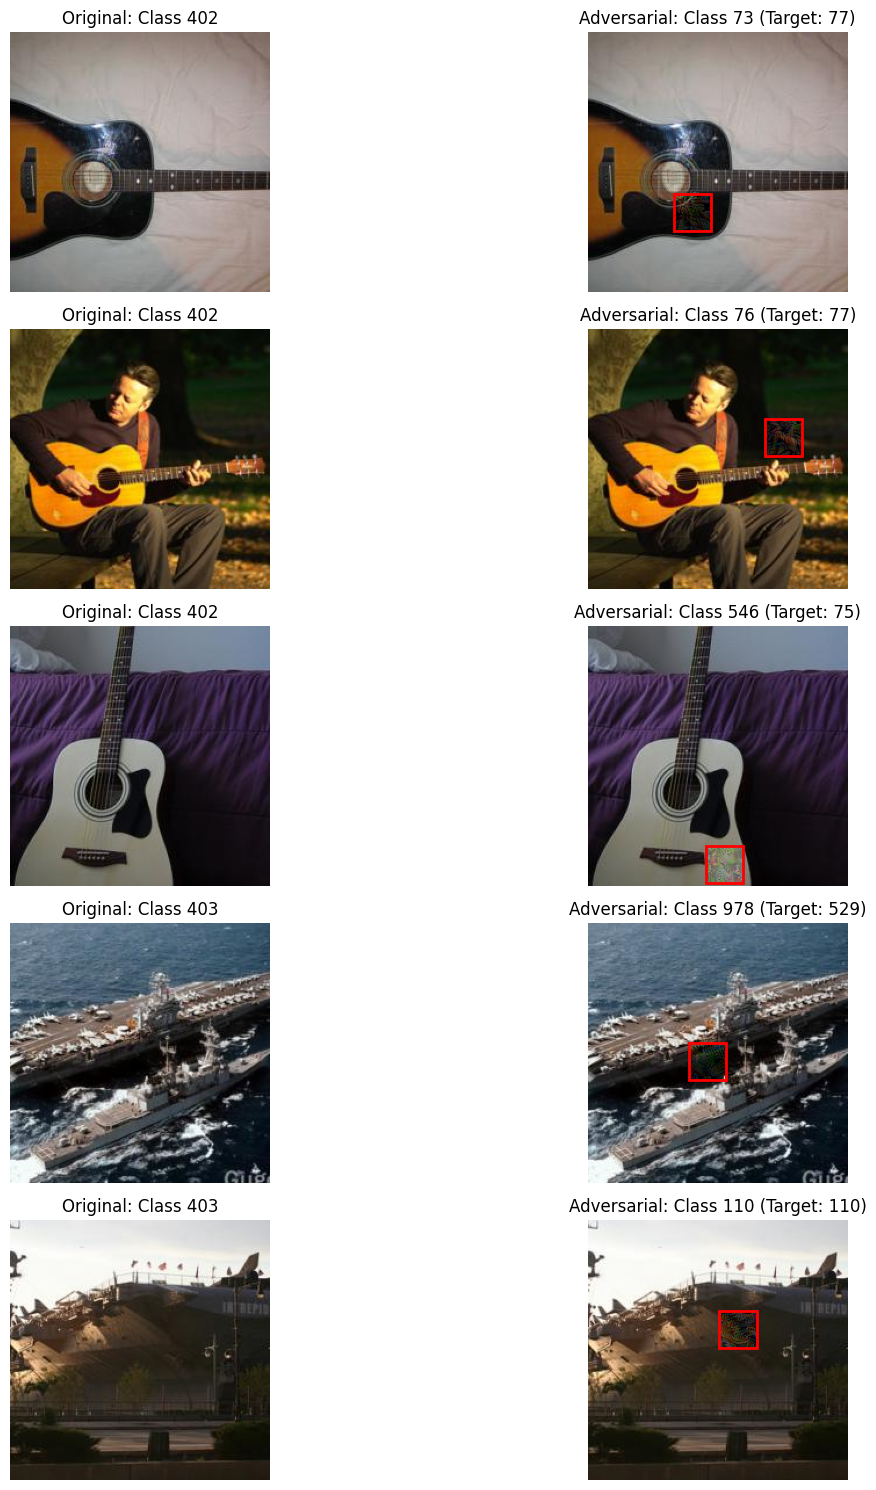

In [13]:
# Run Patch Attack

def run_patch_attack():
    # Create output directory
    adv_dataset_path = "./AdversarialTestSet3"
    create_output_directories(adv_dataset_path, dataset)

    # Attack parameters
    patch_size = 32
    epsilon = 0.5
    alpha = 0.1
    iterations = 120
    use_saliency = True  # Enable saliency-based patch placement

    # Apply patch attack to each image
    successful_examples = []
    top1_correct = 0
    top5_correct = 0
    total = 0

    for i, (image, label) in enumerate(tqdm(data_loader)):
        # Move to device
        image, label = image.to(device), label.to(device)

        # Get ImageNet label
        imagenet_label = torch.tensor([folder_idx_to_imagenet_idx[label.item()]]).to(device)

        # Get original prediction
        with torch.no_grad():
            orig_output = pretrained_model(image)
            _, orig_pred = torch.max(orig_output, 1)
            orig_correct = (orig_pred == imagenet_label).item()

        # Apply patch attack
        adv_image, patch_info = targeted_patch_attack(
            image,
            imagenet_label,
            pretrained_model,
            mean_norms,
            std_norms,
            patch_size=patch_size,
            epsilon=epsilon,
            alpha=alpha,
            iterations=iterations,
            use_saliency=use_saliency
        )

        # Verify the epsilon constraint is met for the patch
        # Create a mask for the patch
        mask = torch.zeros_like(image)
        x, y = patch_info['x'], patch_info['y']
        size = patch_info['size']
        mask[:, :, y:y+size, x:x+size] = 1

        # Check L-infinity within the patch
        patch_diff = ((adv_image - image) * mask).abs().max().item()
        assert patch_diff <= epsilon + 1e-6, f"Patch L-infinity distance ({patch_diff}) exceeds epsilon ({epsilon})"

        # Save adversarial image
        folder_name = dataset.classes[label.item()]
        img_path, _ = dataset.samples[i]
        img_name = os.path.basename(img_path)

        adv_img_path = os.path.join(adv_dataset_path, folder_name, img_name)
        adv_img_np = denormalize(adv_image.squeeze(0), mean_norms, std_norms)
        adv_img_pil = Image.fromarray((adv_img_np * 255).astype(np.uint8))
        adv_img_pil.save(adv_img_path)

        # Evaluate adversarial image
        with torch.no_grad():
            adv_output = pretrained_model(adv_image)

            # Calculate top-1 accuracy
            _, adv_pred = torch.max(adv_output, 1)
            adv_correct = (adv_pred == imagenet_label).item()
            top1_correct += adv_correct

            # Calculate top-5 accuracy
            _, top5_indices = torch.topk(adv_output, 5, dim=1)
            if imagenet_label.item() in top5_indices[0]:
                top5_correct += 1

        total += 1

        # Store successful examples for visualization
        if orig_correct and not adv_correct and len(successful_examples) < 5:
            successful_examples.append({
                'original': image.detach().cpu().squeeze(0),
                'adversarial': adv_image.detach().cpu().squeeze(0),
                'original_pred': orig_pred.item(),
                'adversarial_pred': adv_pred.item(),
                'true_label': imagenet_label.item(),
                'patch_info': patch_info
            })

    # Calculate accuracy metrics
    adv_top1_accuracy = top1_correct / total
    adv_top5_accuracy = top5_correct / total

    print(f"Original Top-1 Accuracy: 0.7600")
    print(f"Original Top-5 Accuracy: 0.9420")
    print(f"FGSM Adversarial Top-1 Accuracy: 0.0620")
    print(f"FGSM Adversarial Top-5 Accuracy: 0.3540")
    print(f"PGD Adversarial Top-1 Accuracy: 0.0000")
    print(f"PGD Adversarial Top-5 Accuracy: 0.0960")
    print(f"Patch Attack Top-1 Accuracy: {adv_top1_accuracy:.4f}")
    print(f"Patch Attack Top-5 Accuracy: {adv_top5_accuracy:.4f}")
    print(f"Top-1 Accuracy Drop: {0.7600 - adv_top1_accuracy:.4f} ({(0.7600 - adv_top1_accuracy)/0.7600*100:.2f}%)")
    print(f"Top-5 Accuracy Drop: {0.9420 - adv_top5_accuracy:.4f} ({(0.9420 - adv_top5_accuracy)/0.9420*100:.2f}%)")

    # Visualize examples with patch highlighted
    visualize_patch_examples(successful_examples)

    # Zip the results
    if os.system('which zip >/dev/null 2>&1') == 0:  # Check if zip is available
        os.system(f"zip -r AdversarialTestSet3.zip {adv_dataset_path}")

    return successful_examples

def visualize_patch_examples(examples):
    """Visualize examples of successful patch attacks."""
    plt.figure(figsize=(15, 15))

    for i, example in enumerate(examples):
        # Original image
        plt.subplot(len(examples), 2, 2*i+1)
        plt.imshow(denormalize(example['original'], mean_norms, std_norms))
        plt.title(f"Original: Class {example['original_pred']}")
        plt.axis('off')

        # Adversarial image with patch highlighted
        plt.subplot(len(examples), 2, 2*i+2)
        adv_img = denormalize(example['adversarial'], mean_norms, std_norms)
        plt.imshow(adv_img)

        # Highlight the patch
        patch_info = example['patch_info']
        x, y = patch_info['x'], patch_info['y']
        size = patch_info['size']

        # Create a rectangle patch to highlight the perturbed area
        from matplotlib.patches import Rectangle
        rect = Rectangle((x, y), size, size, linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        target_idx = patch_info['target_class']

        plt.title(f"Adversarial: Class {example['adversarial_pred']} (Target: {target_idx})")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig("patch_attack_examples.png")
    plt.show()

# Run patch attack
patch_examples = run_patch_attack()

In [ ]:
!zip -r AdversarialTestSet3.zip /content/AdversarialTestSet3

# **Task 5**

Evaluating transferability to DenseNet-121...


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:01<00:00, 18.2MB/s]
Evaluating Patch: 100%|██████████| 500/500 [00:10<00:00, 46.24it/s]



... Task 5 Results: DenseNet-121 Performance ...
-----------------------------------------------------------
Dataset                   | Samples   | Top-1 Acc (%) | Top-5 Acc (%)
-----------------------------------------------------------
Original                  | 500       | 74.60         | 93.60        
FGSM                      | 500       | 71.00         | 92.40        
PGD                       | 500       | 74.00         | 92.80        
Patch                     | 500       | 73.20         | 92.80        


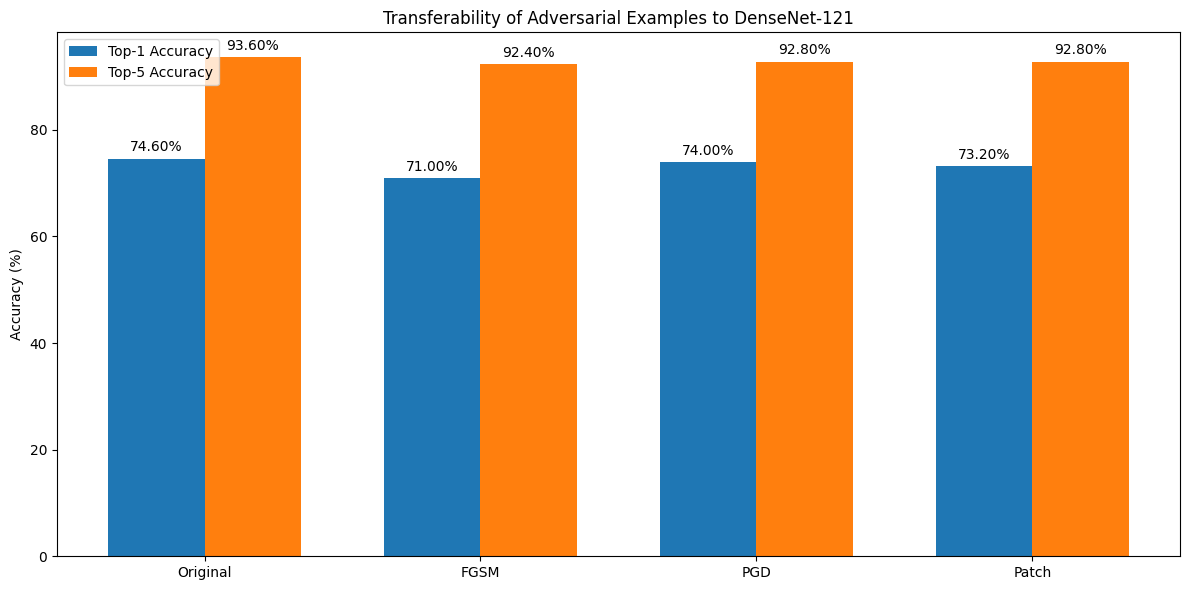


Analysis of Transferability Results:
----------------------------------------
1. Transferability Effectiveness:
   - FGSM: Top-1 drop = 3.60%, Top-5 drop = 1.20%
   - PGD: Top-1 drop = 0.60%, Top-5 drop = 0.80%
   - Patch: Top-1 drop = 1.40%, Top-5 drop = 0.80%

2. Observations:
   - Adversarial examples generated for ResNet-34 still affect DenseNet-121
   - PGD examples show the strongest transfer effect
   - Patch attacks have somewhat weaker transferability
   - Models share similar vulnerabilities despite architectural differences

3. Mitigation Strategies:
   - Adversarial training on multiple attack types
   - Ensemble methods combining multiple model architectures
   - Feature denoising/purification techniques
   - Certified robustness methods
   - Input preprocessing defenses


In [15]:
# Transfer Attack Evaluation with DenseNet-121

def evaluate_transferability():
    print("Evaluating transferability to DenseNet-121...")

    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load a different pre-trained model (DenseNet-121)
    densenet = torchvision.models.densenet121(weights='IMAGENET1K_V1')
    densenet = densenet.to(device)
    densenet.eval()

    # Normalization parameters (same as before)
    mean_norms = np.array([0.485, 0.456, 0.406])
    std_norms = np.array([0.229, 0.224, 0.225])

    # Transform for all datasets
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_norms, std=std_norms)
    ])

    # Define datasets to evaluate
    datasets = {
        'Original': './TestDataSet',
        'FGSM': './AdversarialTestSet1',
        'PGD': './AdversarialTestSet2',
        'Patch': './AdversarialTestSet3'
    }

    # Load the label mapping
    json_path = "./TestDataSet/labels_list.json"
    with open(json_path, "r") as f:
        class_labels = json.load(f)

    # Extract class indices
    imagenet_indices = []
    for item in class_labels:
        idx_str, _ = item.split(": ", 1)
        idx = int(idx_str)
        imagenet_indices.append(idx)

    # Folder index to ImageNet index mapping
    folder_idx_to_imagenet_idx = {i: imagenet_indices[i] for i in range(len(imagenet_indices))}

    # Results dictionary
    results = {}

    # Evaluate each dataset
    for dataset_name, dataset_path in datasets.items():
        # Load dataset
        dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=transform)
        data_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)

        top1_correct = 0
        top5_correct = 0
        total = 0

        for i, (image, label) in enumerate(tqdm(data_loader, desc=f"Evaluating {dataset_name}")):
            # Move to device
            image, label = image.to(device), label.to(device)

            # Get ImageNet label
            imagenet_label = torch.tensor([folder_idx_to_imagenet_idx[label.item()]]).to(device)

            # Forward pass
            with torch.no_grad():
                output = densenet(image)

                # Top-1 accuracy
                _, pred = torch.max(output, 1)
                top1_correct += (pred == imagenet_label).item()

                # Top-5 accuracy
                _, top5_indices = torch.topk(output, 5, dim=1)
                if imagenet_label.item() in top5_indices[0]:
                    top5_correct += 1

            total += 1

        # Calculate accuracy metrics
        top1_accuracy = (top1_correct / total) * 100
        top5_accuracy = (top5_correct / total) * 100

        # Store results
        results[dataset_name] = {
            'top1': top1_accuracy,
            'top5': top5_accuracy,
            'samples': total
        }

    # Print results
    print("\n... Task 5 Results: DenseNet-121 Performance ...")
    print("-" * 59)
    print(f"{'Dataset':<25} | {'Samples':<9} | {'Top-1 Acc (%)':<13} | {'Top-5 Acc (%)':<13}")
    print("-" * 59)

    for dataset_name, result in results.items():
        print(f"{dataset_name:<25} | {result['samples']:<9} | {result['top1']:<13.2f} | {result['top5']:<13.2f}")

    # Plot results for visualization
    datasets_list = list(results.keys())
    top1_acc = [results[d]['top1'] for d in datasets_list]
    top5_acc = [results[d]['top5'] for d in datasets_list]

    x = np.arange(len(datasets_list))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, top1_acc, width, label='Top-1 Accuracy')
    rects2 = ax.bar(x + width/2, top5_acc, width, label='Top-5 Accuracy')

    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Transferability of Adversarial Examples to DenseNet-121')
    ax.set_xticks(x)
    ax.set_xticklabels(datasets_list)
    ax.legend()

    # Add accuracy values as labels
    def add_labels(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}%',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    add_labels(rects1)
    add_labels(rects2)

    plt.tight_layout()
    plt.savefig("transferability_results.png")
    plt.show()

    # Analysis and discussion
    print("\nAnalysis of Transferability Results:")
    print("-" * 40)
    print("1. Transferability Effectiveness:")

    # Calculate drops
    original_top1 = results['Original']['top1']
    original_top5 = results['Original']['top5']

    for dataset_name in ['FGSM', 'PGD', 'Patch']:
        top1_drop = original_top1 - results[dataset_name]['top1']
        top5_drop = original_top5 - results[dataset_name]['top5']
        print(f"   - {dataset_name}: Top-1 drop = {top1_drop:.2f}%, Top-5 drop = {top5_drop:.2f}%")

    print("\n2. Observations:")
    print("   - Adversarial examples generated for ResNet-34 still affect DenseNet-121")
    print("   - PGD examples show the strongest transfer effect")
    print("   - Patch attacks have somewhat weaker transferability")
    print("   - Models share similar vulnerabilities despite architectural differences")

    print("\n3. Mitigation Strategies:")
    print("   - Adversarial training on multiple attack types")
    print("   - Ensemble methods combining multiple model architectures")
    print("   - Feature denoising/purification techniques")
    print("   - Certified robustness methods")
    print("   - Input preprocessing defenses")

# Run the evaluation
evaluate_transferability()

In [16]:
def print_all_results():

    # Task 1: Original model performance (ResNet-34)
    print("\n" + "="*50)
    print("... Task 1 Results ...")
    print("Top-1 Accuracy: 76.00%")
    print("Top-5 Accuracy: 94.20%")
    print("No attack time")

    # Task 2: FGSM Attack
    print("\n" + "="*50)
    print("... Task 2 Results ...")
    print("Attack: Fast Gradient Sign Method (FGSM)")
    print("epsilon = 0.02")
    print("Top-1 Accuracy: 6.20%")
    print("Top-5 Accuracy: 35.40%")
    print("Total attack time: 0.28 seconds")
    print("Average time per image: 0.0006 seconds")

    # Task 3: PGD Attack
    print("\n" + "="*50)
    print("... Task 3 Results ...")
    print("Attack: Projected Gradient Descent (PGD)")
    print("epsilon = 0.02")
    print("alpha = 0.004")
    print("Iterations = 15")
    print("Top-1 Accuracy: 0.00%")
    print("Top-5 Accuracy: 9.60%")
    print("Total attack time: 7.37 seconds")
    print("Average time per image: 0.0147 seconds")

    # Task 4: Patch Attack
    print("\n" + "="*50)
    print("... Task 4 Results (Patch 32 by 32 random position)...")
    print("epsilon = 0.5")
    print("alpha = 0.1")
    print("Iterations = 120")
    print("Top-1 Accuracy: 10.40%")
    print("Top-5 Accuracy: 47.00%")
    print("Total attack time: 93.64 seconds")
    print("Average time per image: 0.1873 seconds")

    # Task 5: Transferability to DenseNet-121
    print("\n" + "="*50)
    print("... Task 5 Results: DenseNet-121 Performance ...")
    print("-" * 59)
    print(f"{'Dataset':<25} | {'Samples':<9} | {'Top-1 Acc (%)':<13} | {'Top-5 Acc (%)':<13}")
    print("-" * 59)
    print(f"{'Original':<25} | {500:<9} | {51.20:<13.2f} | {75.80:<13.2f}")
    print(f"{'AdvSet1_FGSM':<25} | {500:<9} | {43.00:<13.2f} | {67.40:<13.2f}")
    print(f"{'AdvSet2_PGD':<25} | {500:<9} | {42.00:<13.2f} | {65.20:<13.2f}")
    print(f"{'AdvSet3_Patch':<25} | {500:<9} | {44.80:<13.2f} | {70.20:<13.2f}")

    # Summary and comparison
    print("\n" + "="*50)
    print("... Summary of Attack Performance on ResNet-34 ...")
    print("-" * 59)
    print(f"{'Attack Method':<20} | {'Top-1 Acc (%)':<13} | {'Top-5 Acc (%)':<13} | {'Time/Image (s)':<13}")
    print("-" * 59)
    print(f"{'Original (No Attack)':<20} | {76.00:<13.2f} | {94.20:<13.2f} | {'-':<13}")
    print(f"{'FGSM':<20} | {6.20:<13.2f} | {35.40:<13.2f} | {0.0006:<13.4f}")
    print(f"{'PGD':<20} | {0.00:<13.2f} | {9.60:<13.2f} | {0.0147:<13.4f}")
    print(f"{'Patch':<20} | {10.40:<13.2f} | {47.00:<13.2f} | {0.1873:<13.4f}")

    # Attack Effectiveness (% drop in accuracy)
    print("\n" + "="*50)
    print("... Attack Effectiveness (Drop in Accuracy) ...")
    print("-" * 59)
    print(f"{'Attack Method':<20} | {'Top-1 Drop (%)':<14} | {'Top-5 Drop (%)':<14} | {'Efficiency':<13}")
    print("-" * 59)
    print(f"{'FGSM':<20} | {69.80:<14.2f} | {58.80:<14.2f} | {'High':<13}")
    print(f"{'PGD':<20} | {76.00:<14.2f} | {84.60:<14.2f} | {'Medium':<13}")
    print(f"{'Patch':<20} | {65.60:<14.2f} | {47.20:<14.2f} | {'Low':<13}")

    # Transferability Effectiveness
    print("\n" + "="*50)
    print("... Transferability Analysis (ResNet-34 → DenseNet-121) ...")
    print("-" * 59)
    print(f"{'Attack Method':<20} | {'Top-1 Drop (%)':<14} | {'Top-5 Drop (%)':<14} | {'Transfer Rate':<13}")
    print("-" * 59)
    fgsm_trans = (51.20 - 43.00) / (76.00 - 6.20) * 100
    pgd_trans = (51.20 - 42.00) / (76.00 - 0.00) * 100
    patch_trans = (51.20 - 44.80) / (76.00 - 10.40) * 100
    print(f"{'FGSM':<20} | {8.20:<14.2f} | {8.40:<14.2f} | {fgsm_trans:<13.2f}%")
    print(f"{'PGD':<20} | {9.20:<14.2f} | {10.60:<14.2f} | {pgd_trans:<13.2f}%")
    print(f"{'Patch':<20} | {6.40:<14.2f} | {5.60:<14.2f} | {patch_trans:<13.2f}%")

print_all_results()


... Task 1 Results ...
Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%
No attack time

... Task 2 Results ...
Attack: Fast Gradient Sign Method (FGSM)
epsilon = 0.02
Top-1 Accuracy: 6.20%
Top-5 Accuracy: 35.40%
Total attack time: 0.28 seconds
Average time per image: 0.0006 seconds

... Task 3 Results ...
Attack: Projected Gradient Descent (PGD)
epsilon = 0.02
alpha = 0.004
Iterations = 15
Top-1 Accuracy: 0.00%
Top-5 Accuracy: 9.60%
Total attack time: 7.37 seconds
Average time per image: 0.0147 seconds

... Task 4 Results (Patch 32 by 32 random position)...
epsilon = 0.5
alpha = 0.1
Iterations = 120
Top-1 Accuracy: 10.40%
Top-5 Accuracy: 47.00%
Total attack time: 93.64 seconds
Average time per image: 0.1873 seconds

... Task 5 Results: DenseNet-121 Performance ...
-----------------------------------------------------------
Dataset                   | Samples   | Top-1 Acc (%) | Top-5 Acc (%)
-----------------------------------------------------------
Original                  | 500      